In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
#!cp -r /content/data/Eye_diseases/  /content/mydrive/MyDrive


In [ ]:
#!mkdir -r /content/mydrive/MyDrive/Data
#!cp -r /content/mydrive/MyDrive/Eye_diseases  /content/mydrive/MyDrive/Data

# Data Preprocessing

Pembagian dataset

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


main_dir = '/content/mydrive/MyDrive/data_capstone'

img_paths = []
labels = []

for class_dir in os.listdir(main_dir):
  class_path = os.path.join(main_dir, class_dir)
  for img_file in os.listdir(class_path):
    img_path = os.path.join(class_path, img_file)
    img_paths.append(img_path)
    labels.append(class_dir)

label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(labels)

target_column_hotcoded = to_categorical(encoded_labels, num_classes=len(set(labels)))

X, Y = shuffle(img_paths, target_column_hotcoded, random_state=2)
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.3, random_state=2)

train_dir = '/content/mydrive/MyDrive/data_capstone/train_folder'
val_dir = '/content/mydrive/MyDrive/data_capstone/val_folder'
#test_dir = '/content/mydrive/MyDrive/data_capstone/test_folder'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
#os.makedirs(test_dir, exist_ok=True)

for img_path, label in zip(X_train, y_train):
    class_folder = os.path.join(train_dir, str(label.argmax()))
    os.makedirs(class_folder, exist_ok=True)
    shutil.copy(img_path, os.path.join(class_folder, os.path.basename(img_path)))

for img_path, label in zip(X_val, y_val):
    class_folder = os.path.join(val_dir, str(label.argmax()))
    os.makedirs(class_folder, exist_ok=True)
    shutil.copy(img_path, os.path.join(class_folder, os.path.basename(img_path)))

'''for img_path, label in zip(X_test, y_test):
    class_folder = os.path.join(test_dir, str(label.argmax()))
    os.makedirs(class_folder, exist_ok=True)
    shutil.copy(img_path, os.path.join(class_folder, os.path.basename(img_path)))
'''


IsADirectoryError: ignored

In [ ]:
'''
deleted_dir = ['Bulging_Eyes', 'Cataracts', 'Crossed_Eyes', 'Glaucoma', 'Uveitis', 'normal']

for folder_name in deleted_dir:
  folder_path = os.path.join(main_folder, folder_name)

  try:
    shutil.rmtree(folder_path)
    print(f"Folder '{folder_name}' deleted successfully")
  except FileNotFoundError:
    print(f"Folder '{folder_name}' not found")
  except Exception as e:
    print(f"An error occurred while deleting the folder '{folder_name}': {str(e)}")
'''


In [ ]:
'''
!rm -r '/content/mydrive/MyDrive/Dataset/train_dir/train_dir'
!rm -r '/content/mydrive/MyDrive/Dataset/val_dir/train_dir'
'''

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen =  ImageDataGenerator(rescale=1./255)

batch_size = 32


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)


validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)




Found 361 images belonging to 6 classes.
Found 150 images belonging to 6 classes.


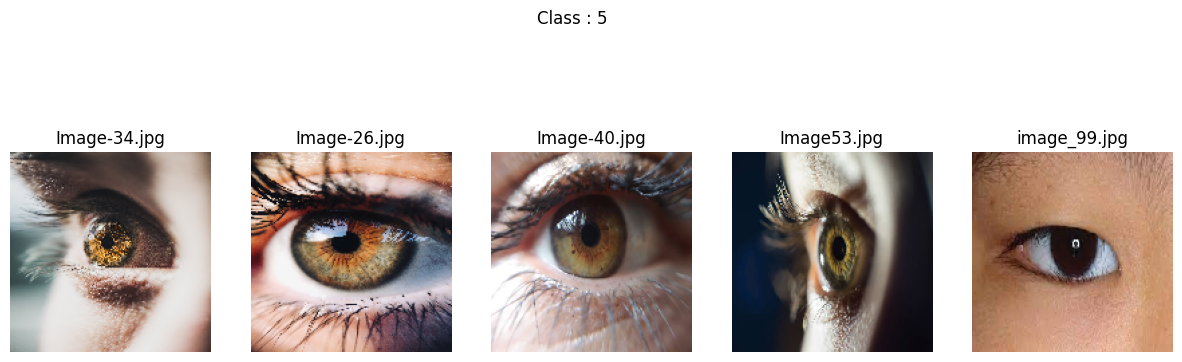

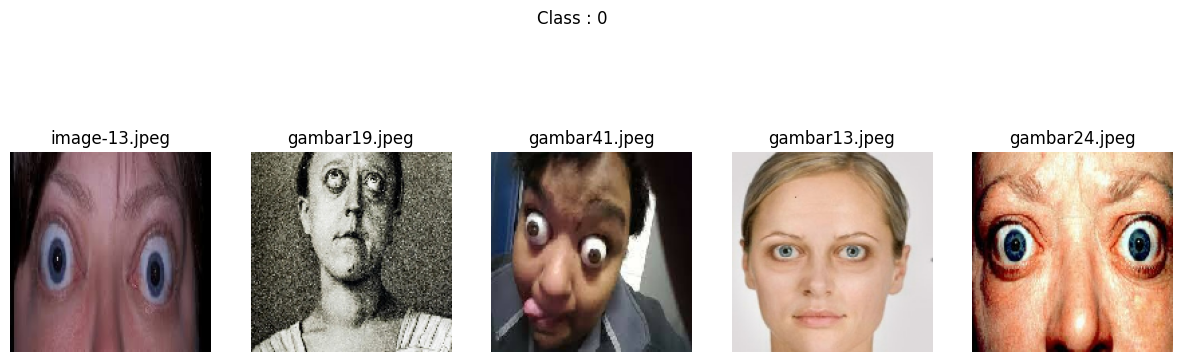

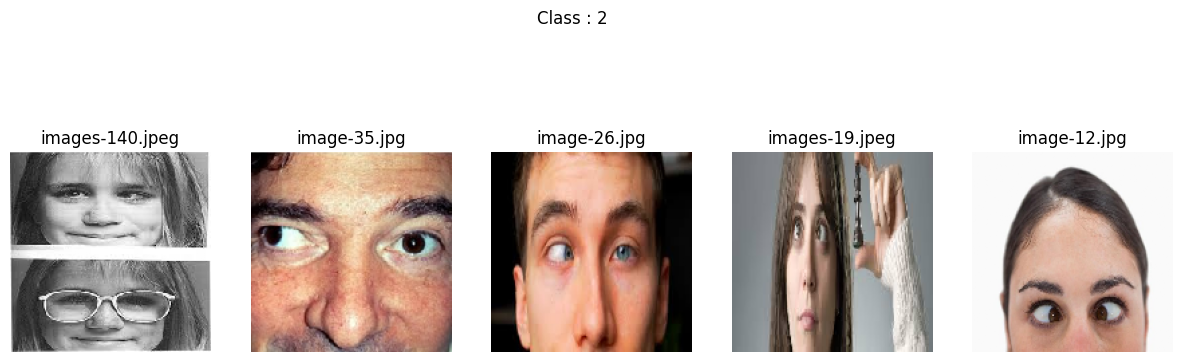

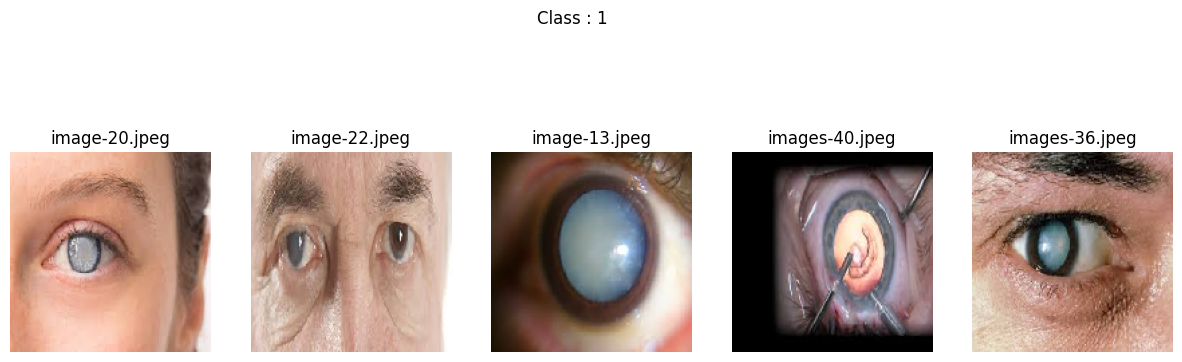

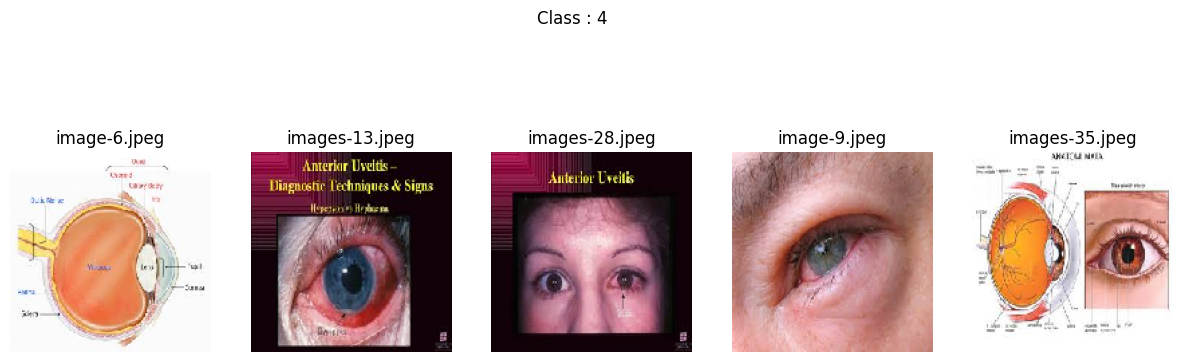

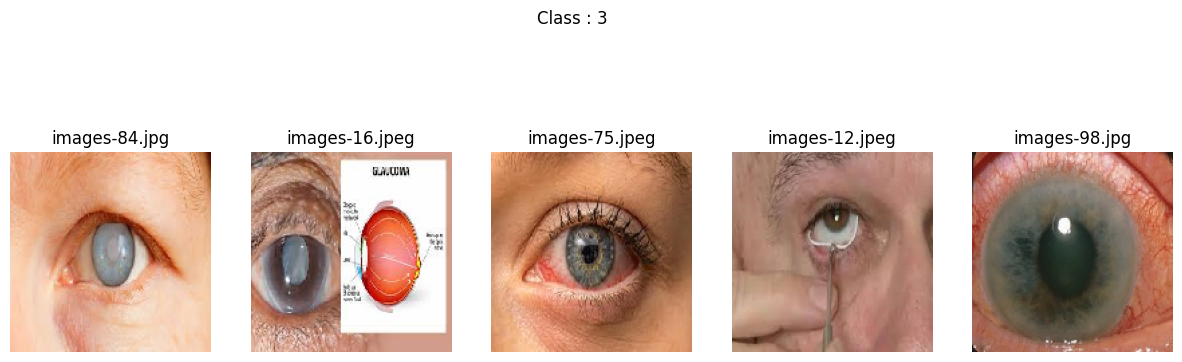

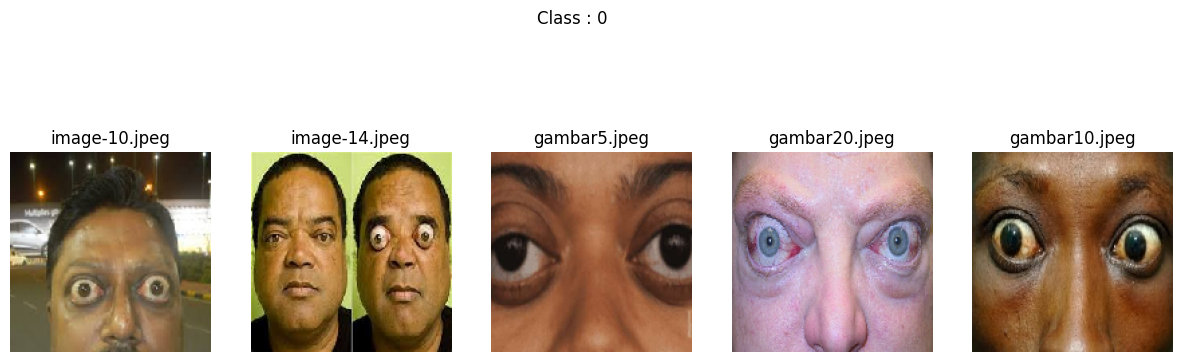

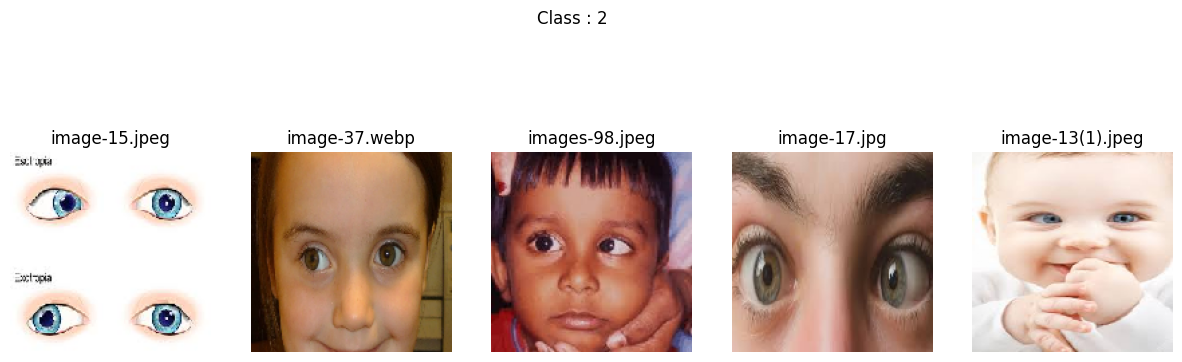

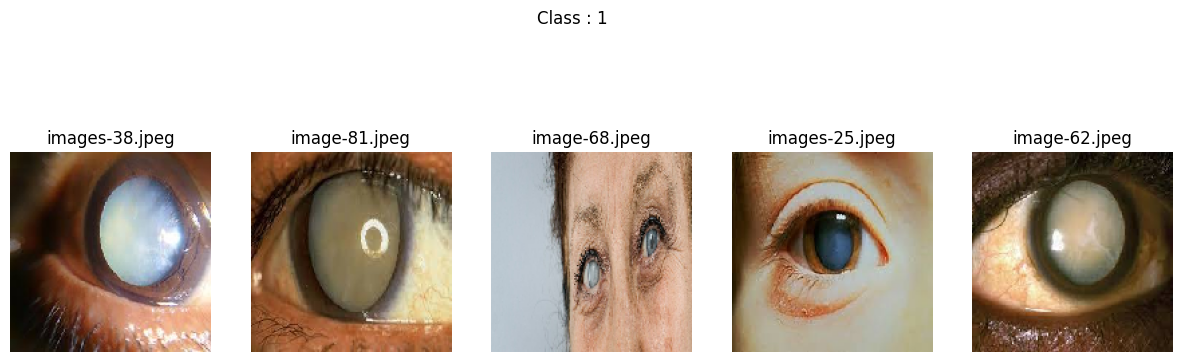

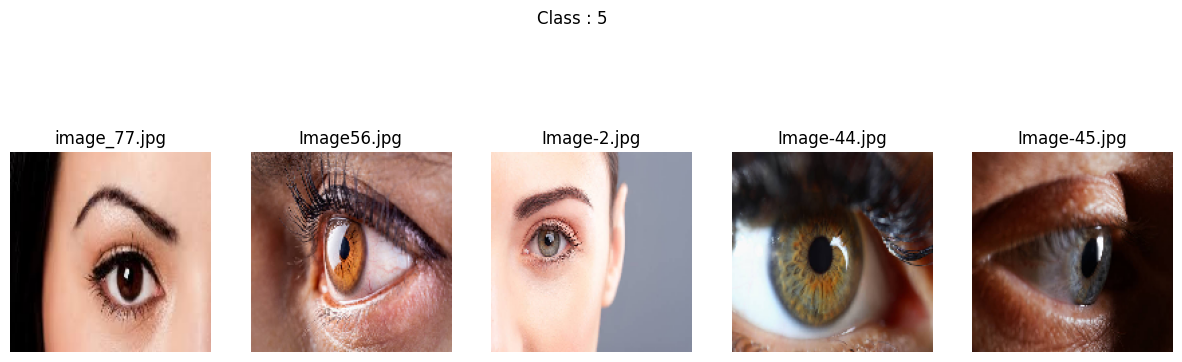

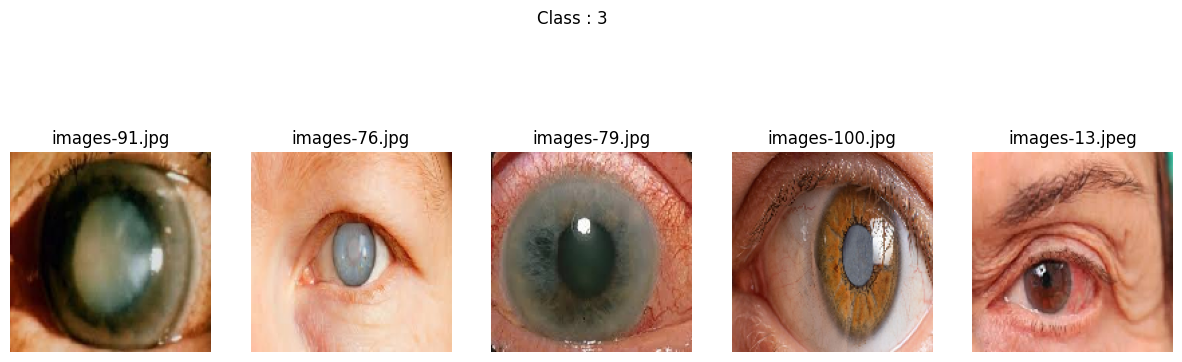

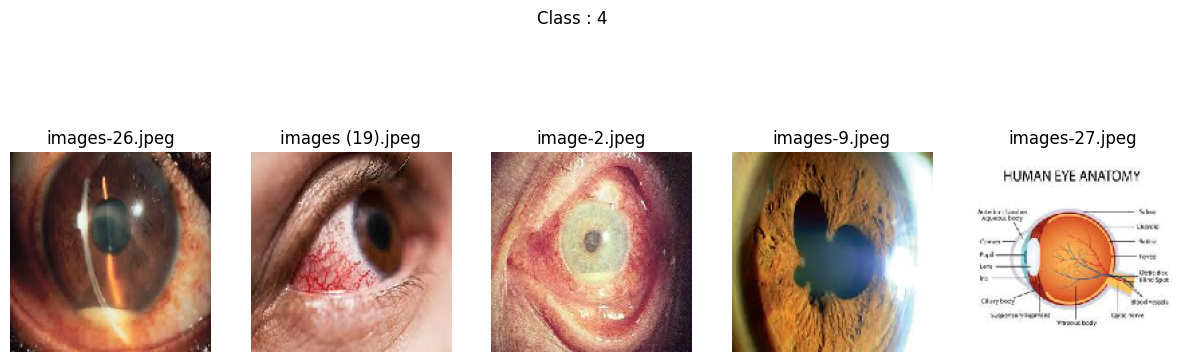

In [ ]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def display_random_img(directory, num_images=5):
  classes = os.listdir(directory)

  for class_name in classes:
    class_dir = os.path.join(directory, class_name)
    file_list = os.listdir(class_dir)
    random_files = random.sample(file_list, min(num_images, len(file_list)))

    plt.figure(figsize=(15,5))
    for i, file_name in enumerate(random_files, 1):
      file_path = os.path.join(class_dir, file_name)
      if os.path.isfile(file_path):
        image = load_img(file_path, target_size=(150,150))
        img_array = img_to_array(image)

        plt.subplot(1, num_images, i)
        plt.imshow(img_array / 255.0)
        plt.title(file_name)
        plt.axis('off')
      else:
        print(f"Skipping {file_name} in class {class_name} as it is a directory.")

    plt.suptitle(f"Class : {class_name}")
    plt.show()


display_random_img(train_dir)
display_random_img(val_dir)

In [ ]:
class_names = train_generator.class_indices.keys()
print(class_names)

dict_keys(['0', '1', '2', '3', '4', '5'])


In [ ]:
'''from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch):
    initial_learning_rate = 0.01
    decay = 0.96
    epoch_drop = 8
    learning_rate = initial_learning_rate * decay**(epoch // epoch_drop)
    return learning_rate

# Callback for Learning Rate Scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)'''

Create Model

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2



num_classes = len(class_names)
input_shape = (224, 224, 3 )

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(input_shape))

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 27563334 (105.15 MB)
Trainable params: 27563334 (105.15 MB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

base_model.trainable = False

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
epochs = 30
hist = model.fit(
    train_generator,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data= validation_generator,
    #callbacks = [early_stopping]

)

Epoch 1/30
12/12 [==============================] - 387s 32s/step - loss: 1.9810 - accuracy: 0.2382 - val_loss: 1.3877 - val_accuracy: 0.5133
Epoch 2/30
12/12 [==============================] - 347s 29s/step - loss: 1.6525 - accuracy: 0.3463 - val_loss: 1.3518 - val_accuracy: 0.4267
Epoch 3/30
12/12 [==============================] - 340s 29s/step - loss: 1.5838 - accuracy: 0.3629 - val_loss: 1.2338 - val_accuracy: 0.5000
Epoch 4/30
12/12 [==============================] - 385s 33s/step - loss: 1.4769 - accuracy: 0.4211 - val_loss: 1.2187 - val_accuracy: 0.5867
Epoch 5/30
12/12 [==============================] - 341s 29s/step - loss: 1.4140 - accuracy: 0.4432 - val_loss: 1.1891 - val_accuracy: 0.5733
Epoch 6/30
12/12 [==============================] - 386s 33s/step - loss: 1.3347 - accuracy: 0.4488 - val_loss: 1.1386 - val_accuracy: 0.6067
Epoch 7/30
12/12 [==============================] - 386s 33s/step - loss: 1.3173 - accuracy: 0.5014 - val_loss: 1.1533 - val_accuracy: 0.5800
Epoch 

<ipython-input-19-a4a357285e08>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values, 'b',  color='blue', label='Training loss')
<ipython-input-19-a4a357285e08>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss_values, 'b', color='red', label='Validation loss' )


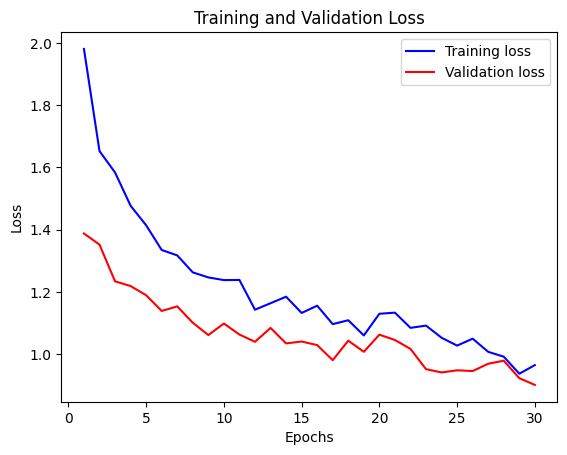

<ipython-input-19-a4a357285e08>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc_values, 'b', color='blue', label='Training accuracy')
<ipython-input-19-a4a357285e08>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc_values, 'b', color='red',label='Validation accuracy' )


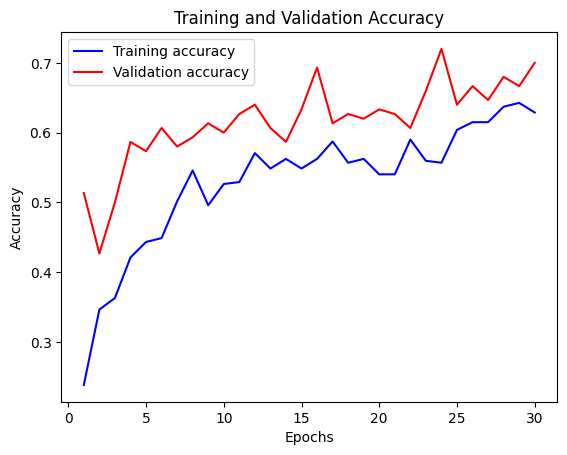

In [ ]:
import matplotlib.pyplot as plt

# Melihat metrik pelatihan dan validasi dari objek history
history_dict = hist.history

# Plot loss pada set pelatihan dan set validasi
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b',  color='blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', color='red', label='Validation loss' )
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot akurasi pada set pelatihan dan set validasi
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'b', color='blue', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', color='red',label='Validation accuracy' )
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
base_model.trainable = True

# Menetapkan beberapa lapisan terakhir yang tetap bebas
for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

# Melanjutkan pelatihan dengan model yang sebelumnya dilatih
history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)


Epoch 1/10
12/12 [==============================] - 634s 53s/step - loss: 0.9865 - accuracy: 0.6177 - val_loss: 0.8803 - val_accuracy: 0.7000
Epoch 2/10
12/12 [==============================] - 635s 53s/step - loss: 0.8403 - accuracy: 0.6870 - val_loss: 0.8642 - val_accuracy: 0.7333
Epoch 3/10
12/12 [==============================] - 584s 49s/step - loss: 0.9014 - accuracy: 0.6482 - val_loss: 0.8216 - val_accuracy: 0.7267
Epoch 4/10
12/12 [==============================] - 587s 49s/step - loss: 0.8090 - accuracy: 0.7008 - val_loss: 0.8157 - val_accuracy: 0.6933
Epoch 5/10
12/12 [==============================] - 588s 49s/step - loss: 0.7369 - accuracy: 0.7285 - val_loss: 0.7520 - val_accuracy: 0.7267
Epoch 6/10
12/12 [==============================] - 632s 56s/step - loss: 0.7043 - accuracy: 0.7202 - val_loss: 0.7569 - val_accuracy: 0.7533
Epoch 7/10
12/12 [==============================] - 630s 53s/step - loss: 0.6961 - accuracy: 0.7341 - val_loss: 0.7355 - val_accuracy: 0.7333
Epoch 

<ipython-input-23-76ea57aedf31>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, loss_values, 'b',  color='blue', label='Training loss')
<ipython-input-23-76ea57aedf31>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss_values, 'b', color='red', label='Validation loss' )


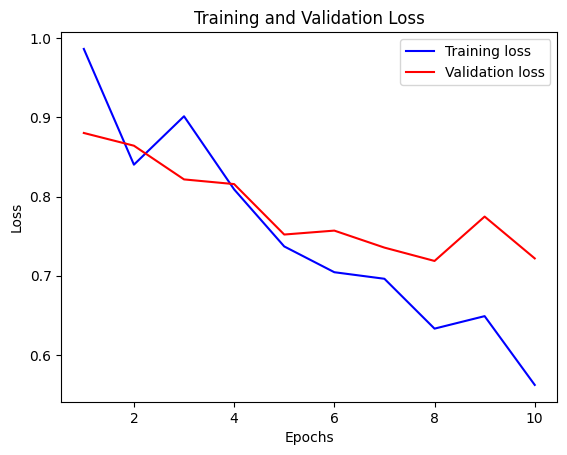

<ipython-input-23-76ea57aedf31>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, acc_values, 'b', color='blue', label='Training accuracy')
<ipython-input-23-76ea57aedf31>:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_acc_values, 'b', color='red',label='Validation accuracy' )


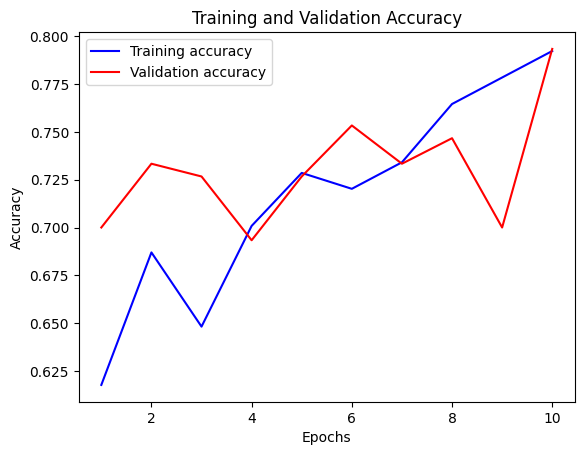

In [ ]:
import matplotlib.pyplot as plt

# Melihat metrik pelatihan dan validasi dari objek history
history_fine_tune_dict = history_fine_tune.history

# Plot loss pada set pelatihan dan set validasi
loss_values = history_fine_tune_dict['loss']
val_loss_values = history_fine_tune_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'b',  color='blue', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', color='red', label='Validation loss' )
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot akurasi pada set pelatihan dan set validasi
acc_values = history_fine_tune_dict['accuracy']
val_acc_values = history_fine_tune_dict['val_accuracy']

plt.plot(epochs, acc_values, 'b', color='blue', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', color='red',label='Validation accuracy' )
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
print("Loss of the model is - " , model.evaluate(validation_generator)[0])
print("Accuracy of the model is - " , model.evaluate(validation_generator)[1]*100 , "%")

5/5 [==============================] - 99s 19s/step - loss: 0.7218 - accuracy: 0.7933
Loss of the model is -  0.7218195199966431
5/5 [==============================] - 98s 19s/step - loss: 0.7218 - accuracy: 0.7933
Accuracy of the model is -  79.3333351612091 %


In [ ]:
#Prediction image
from tensorflow.keras.preprocessing import image
import numpy as np
img_path = '/content/mydrive/MyDrive/Folder tanpa nama/oke.jpg'
img = image.load_img(img_path, target_size=(input_shape))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalisasi

# Lakukan prediksi
predictions = model.predict(img_array)

1/1 [==============================] - 1s 1s/step


In [ ]:
class_labels = sorted(os.listdir(train_dir))

class_index = np.argmax(predictions)
class_name = class_labels[class_index]

# Print the predicted class
print("Predicted class:", class_name)

Predicted class: 1


In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/mydrive/MyDrive/data_capstone/model_eye_disease.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
